In [1]:
from sys import path
path.append('../tools')
from tools import gen_inputs_outputs, gen_pair_inputs
from tensorflow import keras
from keras import layers, Sequential, Input, metrics
import matplotlib.pyplot as plt

2024-08-21 11:01:47.912831: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 11:01:49.395357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 11:01:50.316034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 11:01:50.318619: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 11:01:51.483957: I tensorflow/core/platform/cpu_feature_gua

In [2]:
# For these calculations, we change the input so that
# the layers are in units of 2
# First create input for a classic model to compare

In [3]:
R = 16
x_train, y_train, S = gen_inputs_outputs(R)

In [4]:
# Creates the unit inputs
def gen_unit_inputs(l):
    return [Input(shape=(2,), name=f'unit_{i}') for i in range(l)]

# Create the units
## Using biases on units has large positive impact on performance
def gen_units(unit_inputs, size, activation, use_biases=True):
    return [layers.Dense(size,
                         activation=activation,
                         use_bias=use_biases,
                         name=f'dense_unit_{i}')(unit_input) for i, unit_input in enumerate(unit_inputs)]

# Concatenate layer of units in pairs return
# layer of units with each of size size
## Using biases on units has large positive impact on performance
def reduce_units(units, size, activation, unit_name='reducer_unit', use_biases=True):
    # Create empty list for new units
    paired_units = [None] * int(len(units) / 2)
    
    # Fill the list with concatenated units (necessary before dense layer)
    for i in range(0, len(units), 2):
        paired_units[int(i/2)] = layers.concatenate(units[i:i+2])
    
    # Return dense layer of size on the concatenated layer
    return [layers.Dense(size, 
                         activation=activation,
                         use_bias=use_biases,
                         name=f'{unit_name}_{i}')(paired_units[i]) for i in range(len(paired_units))]
        

In [5]:
# Plots the binary accuracy of a model
def plot_history(history, name):
    # Create x axis so that it starts at 1 (and not 0)
    # This is not noticeable for large eopchs
    x_points = [i for i in range(1, EPOCHS+1)]

    plt.plot(x_points, history.history['binary_accuracy'], label='Binary Accuracy')
    plt.title(f'{name}: Binary Accuracy')
    plt.legend(loc='lower right')

    plt.show()

In [71]:
# Standard model without unit reduction
## Increase intermediate layer sizes increases performance
## At 2 layers of 8192, perfection is reached after 3 epochs

## At one layer, increases required epochs to 42 (at layer size of 8192)
## Same behaviour is observable with one layer

## One layer size: 1024, perfection after 91 epochs

## First layer 1024 second 4, b_acc: 0.7900 after 500 epochs
## Performance impoves if first layer is 4 and second is 1024
## Hypothesis for the reason: when in second config, first layer
## acts as feature simplifier and then second is complexe enough
## to interpret features. If the other way aroung, then after feature
## extraction with complexe first layer, the second layer is not complexe
## enough to extract features for an output of size 9

## Single layer of 4: reach 0.66 after 500 epochs
## Single layer of 16: reach 0.8076 after 500 epochs
## Single layer of 64: reach 0.9999 after 500 epochs
## Single layer of 128: reach 1 after 500 epochs

## Layers: 16, 16 | reach 0.8573 after 500 epochs
## Layers: 32, 32 | reach 0.9700 after 500 epochs
## Layers: 64, 64 | reach 1 after 96 epochs

## Layers: 4, 64 | reach 0.8709 after 500 epochs
## Layers: 64, 4 | reach 0.7557 after 500 epochs
## Same observation as before relating to inversing
## layer size proportions
## Layers: 8, 64, | reach 0.9011 after 500 epochs
## Layers: 16, 64, | reach 0.9261 after 500 epochs
## Layers: 32, 64, | reach 0.9959 after 500 epochs

## Layers: 4, 4, 4 | reach 0.6205 after 500 epochs
## Layers: 32, 32, 16 | reach 0.9935 after 500 epochs
## Layers: 32, 64, 32 | reach 1 after 138 epochs
## Layers: 16, 32, 16 | reach 0.9121 after 500 epochs
## Layers: 16, 16, 16 | reach 0.8850 after 500 epochs
## Layers: 4, 64, 16 | reach 0.7812 after 500 epochs
## Layers: 32, 32, 32 | reach 1 after 235 epochs

def create_classic_model(plot_model=False):
    inputs = Input(shape=(R,), name='inputs')
    
    x = layers.Dense(32, activation='relu', name='dense_1')(inputs)
    x = layers.Dense(32, activation='relu', name='dense_2')(x)
    x = layers.Dense(32, activation='relu', name='dense_3')(x)

    
    outputs = layers.Dense(S, activation='sigmoid', name='outputs')(x)
    ## Layers: 4, 64, 16 | reach 0.7812 after 500 epochs

    model = keras.Model(inputs=inputs,
                        outputs=outputs)
    
    if plot_model:
        keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=True,
            show_layer_activations=True,
            to_file='classic_model.png'
        )
    
    return model

In [72]:
# Create the classic
cmodel = create_classic_model(plot_model=True)
print(cmodel.count_params())

# Define some parameters
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['binary_accuracy']

EPOCHS = 500
BATCH_SIZE = 512

# Compile the model
cmodel.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)

# Train the model
history = cmodel.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

2953
Epoch 1/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - binary_accuracy: 0.5301 - loss: 0.6826 
Epoch 2/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - binary_accuracy: 0.6133 - loss: 0.6137
Epoch 3/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - binary_accuracy: 0.6634 - loss: 0.5309
Epoch 4/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - binary_accuracy: 0.7118 - loss: 0.4829
Epoch 5/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - binary_accuracy: 0.7326 - loss: 0.4324
Epoch 6/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - binary_accuracy: 0.7518 - loss: 0.4027
Epoch 7/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - binary_accuracy: 0.7784 - loss: 0.3787
Epoch 8/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - binary_accuracy: 0.7923 - loss: 0.3584
Epoch 9/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - binary_accuracy: 0.8041 - loss: 0.3413
Epoch 10/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - binary_accuracy: 0.8116 - loss: 0.3269
Epoch 11/500
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - binary_accuracy: 0.9788 - loss: 0.0438
Epoch 126/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - binary_accuracy: 0.9791 - loss: 0.0431
Epoch 127/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - binary_accuracy: 0.9794 - loss: 0.0429
Epoch 128/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - binary_accuracy: 0.9794 - loss: 0.0430
Epoch 129/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - binary_accuracy: 0.9800 - loss: 0.0420
Epoch 130/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - binary_accuracy: 0.9800 - loss: 0.0415
Epoch 131/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - binary_accuracy: 0.9803 - loss: 0.0411
Epoch 132/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - binary_accuracy: 0.9801 - loss: 0.0415
Epoch 133/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - binary_accuracy: 0.9806 - loss: 0.0405
Epoch 134/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - binary_accuracy: 0.9809 - loss: 0.0401
Epoch 135/500
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - binary_accuracy: 1.0000 - loss: 6.1409e-04
Epoch 249/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - binary_accuracy: 1.0000 - loss: 5.6864e-04
Epoch 250/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - binary_accuracy: 1.0000 - loss: 5.6889e-04
Epoch 251/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - binary_accuracy: 1.0000 - loss: 5.4567e-04
Epoch 252/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - binary_accuracy: 1.0000 - loss: 5.4733e-04
Epoch 253/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - binary_accuracy: 1.0000 - loss: 5.2857e-04
Epoch 254/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - binary_accuracy: 1.0000 - loss: 5.5542e-04
Epoch 255/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - binary_accuracy: 0.9993 - loss: 0.0026
Epoch 256/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - binary_accuracy: 1.0000 - loss: 5.0892e-04
Epoch 257/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - binary_accuracy: 1.0000 - loss: 4.9431e-0

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - binary_accuracy: 1.0000 - loss: 9.6106e-05
Epoch 369/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - binary_accuracy: 1.0000 - loss: 9.3770e-05
Epoch 370/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - binary_accuracy: 1.0000 - loss: 9.4913e-05
Epoch 371/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - binary_accuracy: 1.0000 - loss: 9.3782e-05
Epoch 372/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - binary_accuracy: 1.0000 - loss: 9.2882e-05
Epoch 373/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - binary_accuracy: 1.0000 - loss: 9.5547e-05
Epoch 374/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - binary_accuracy: 1.0000 - loss: 8.8045e-05
Epoch 375/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - binary_accuracy: 1.0000 - loss: 9.3724e-05
Epoch 376/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - binary_accuracy: 0.9997 - loss: 0.0012    
Epoch 377/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - binary_accuracy: 0.9997 - loss: 9.219

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - binary_accuracy: 1.0000 - loss: 4.6646e-05
Epoch 489/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - binary_accuracy: 1.0000 - loss: 4.6062e-05
Epoch 490/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - binary_accuracy: 1.0000 - loss: 4.6531e-05
Epoch 491/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - binary_accuracy: 1.0000 - loss: 4.7155e-05
Epoch 492/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - binary_accuracy: 1.0000 - loss: 4.4326e-05
Epoch 493/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - binary_accuracy: 1.0000 - loss: 4.5953e-05
Epoch 494/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - binary_accuracy: 1.0000 - loss: 4.4901e-05
Epoch 495/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - binary_accuracy: 1.0000 - loss: 4.5029e-05
Epoch 496/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - binary_accuracy: 1.0000 - loss: 4.3757e-05
Epoch 497/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - binary_accuracy: 1.0000 - loss: 4.262

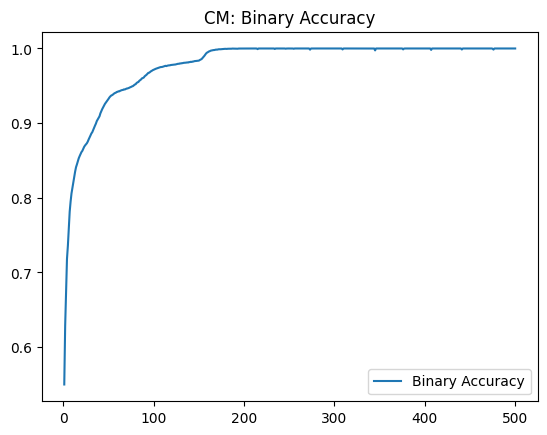

In [73]:
plot_history(history, name='CM')

In [6]:
# Modifie input for unit models
x_train = gen_pair_inputs(x_train)

In [77]:
# First model that we are testing
# Chose whether or not to use biases
def create_model_1(plot_model=False, model_name='model1'):
    # Create the inputs
    inputs = gen_unit_inputs(len(x_train))

    # Create the units
    x = layers.concatenate(gen_units(inputs, 2, activation='relu', use_biases=True))
    
    # Add dense layers
    x = layers.Dense(64, activation='relu', use_bias=True, name='hidden_dense_1')(x)

    # Ouput layer
    outputs = layers.Dense(S, activation='sigmoid', use_bias=True, name='ouput')(x)

    model = keras.Model(
        inputs=inputs,
        outputs=outputs
    )
    
    # Plot the model if specified
    if plot_model:
        keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=True,
            show_layer_activations=True,
            to_file=f'{model_name}.png',
        )
    
    # Return the model
    return model

In [78]:
# Create first model
model1 = create_model_1(plot_model=True)

# Compile and train the moded
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['binary_accuracy']

EPOCHS = 1000
BATCH_SIZE = 512

model1.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)


history = model1.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

## Batch size 512 with dense layer at 64: converges to aroud 0.833

Epoch 1/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - binary_accuracy: 0.5164 - loss: 0.6935
Epoch 2/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - binary_accuracy: 0.5662 - loss: 0.6786
Epoch 3/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - binary_accuracy: 0.5996 - loss: 0.6543
Epoch 4/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - binary_accuracy: 0.6155 - loss: 0.6322
Epoch 5/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - binary_accuracy: 0.6352 - loss: 0.6089
Epoch 6/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - binary_accuracy: 0.6505 - loss: 0.5877
Epoch 7/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - binary_accuracy: 0.6625 - loss: 0.5694
Epoch 8/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - binary_accuracy: 0.6692 - loss: 0.5551
Epoch 9/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - binary_accuracy: 0.6761 - loss: 0.5440
Epoch 10/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - binary_accuracy: 0.6810 - loss: 0.5349
Epoch 11/1000
128/128 ━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - binary_accuracy: 0.8425 - loss: 0.2814
Epoch 125/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - binary_accuracy: 0.8409 - loss: 0.2836
Epoch 126/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - binary_accuracy: 0.8426 - loss: 0.2812
Epoch 127/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - binary_accuracy: 0.8424 - loss: 0.2803
Epoch 128/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - binary_accuracy: 0.8424 - loss: 0.2822
Epoch 129/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - binary_accuracy: 0.8409 - loss: 0.2822
Epoch 130/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - binary_accuracy: 0.8424 - loss: 0.2811
Epoch 131/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - binary_accuracy: 0.8419 - loss: 0.2813
Epoch 132/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - binary_accuracy: 0.8417 - loss: 0.2813
Epoch 133/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - binary_accuracy: 0.8420 - loss: 0.2809
Epoch 134/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - binary_accuracy: 0.8454 - loss: 0.2685
Epoch 247/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - binary_accuracy: 0.8442 - loss: 0.2700
Epoch 248/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - binary_accuracy: 0.8445 - loss: 0.2695
Epoch 249/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - binary_accuracy: 0.8458 - loss: 0.2681
Epoch 250/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - binary_accuracy: 0.8455 - loss: 0.2688
Epoch 251/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - binary_accuracy: 0.8442 - loss: 0.2694
Epoch 252/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8455 - loss: 0.2692
Epoch 253/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - binary_accuracy: 0.8447 - loss: 0.2691
Epoch 254/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - binary_accuracy: 0.8458 - loss: 0.2685
Epoch 255/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - binary_accuracy: 0.8450 - loss: 0.2686
Epoch 256/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - binary_accuracy: 0.8454 - loss: 0.2662
Epoch 369/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8459 - loss: 0.2665
Epoch 370/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - binary_accuracy: 0.8459 - loss: 0.2657
Epoch 371/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - binary_accuracy: 0.8456 - loss: 0.2666
Epoch 372/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - binary_accuracy: 0.8446 - loss: 0.2668
Epoch 373/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - binary_accuracy: 0.8460 - loss: 0.2655
Epoch 374/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8461 - loss: 0.2661
Epoch 375/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - binary_accuracy: 0.8459 - loss: 0.2660
Epoch 376/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8451 - loss: 0.2666
Epoch 377/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8452 - loss: 0.2661
Epoch 378/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8464 - loss: 0.2639
Epoch 491/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - binary_accuracy: 0.8468 - loss: 0.2642
Epoch 492/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - binary_accuracy: 0.8470 - loss: 0.2633
Epoch 493/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - binary_accuracy: 0.8478 - loss: 0.2629
Epoch 494/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8462 - loss: 0.2651
Epoch 495/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8472 - loss: 0.2635
Epoch 496/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - binary_accuracy: 0.8465 - loss: 0.2644
Epoch 497/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8471 - loss: 0.2639
Epoch 498/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - binary_accuracy: 0.8464 - loss: 0.2649
Epoch 499/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - binary_accuracy: 0.8480 - loss: 0.2637
Epoch 500/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - binary_accuracy: 0.8478 - loss: 0.2627
Epoch 613/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - binary_accuracy: 0.8477 - loss: 0.2622
Epoch 614/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - binary_accuracy: 0.8473 - loss: 0.2633
Epoch 615/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - binary_accuracy: 0.8488 - loss: 0.2622
Epoch 616/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - binary_accuracy: 0.8477 - loss: 0.2625
Epoch 617/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - binary_accuracy: 0.8470 - loss: 0.2629
Epoch 618/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - binary_accuracy: 0.8470 - loss: 0.2631
Epoch 619/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - binary_accuracy: 0.8474 - loss: 0.2628
Epoch 620/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - binary_accuracy: 0.8473 - loss: 0.2624
Epoch 621/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - binary_accuracy: 0.8470 - loss: 0.2630
Epoch 622/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - binary_accuracy: 0.8460 - loss: 0.2630
Epoch 735/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - binary_accuracy: 0.8485 - loss: 0.2620
Epoch 736/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - binary_accuracy: 0.8473 - loss: 0.2626
Epoch 737/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - binary_accuracy: 0.8462 - loss: 0.2631
Epoch 738/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - binary_accuracy: 0.8480 - loss: 0.2622
Epoch 739/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - binary_accuracy: 0.8459 - loss: 0.2628
Epoch 740/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - binary_accuracy: 0.8484 - loss: 0.2617
Epoch 741/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - binary_accuracy: 0.8482 - loss: 0.2615
Epoch 742/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - binary_accuracy: 0.8474 - loss: 0.2621
Epoch 743/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - binary_accuracy: 0.8476 - loss: 0.2618
Epoch 744/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - binary_accuracy: 0.8482 - loss: 0.2616
Epoch 857/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - binary_accuracy: 0.8474 - loss: 0.2619
Epoch 858/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - binary_accuracy: 0.8477 - loss: 0.2616
Epoch 859/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - binary_accuracy: 0.8474 - loss: 0.2622
Epoch 860/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - binary_accuracy: 0.8466 - loss: 0.2626
Epoch 861/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - binary_accuracy: 0.8474 - loss: 0.2623
Epoch 862/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - binary_accuracy: 0.8472 - loss: 0.2620
Epoch 863/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - binary_accuracy: 0.8473 - loss: 0.2618
Epoch 864/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - binary_accuracy: 0.8457 - loss: 0.2632
Epoch 865/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - binary_accuracy: 0.8480 - loss: 0.2610
Epoch 866/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - binary_accuracy: 0.8472 - loss: 0.2619
Epoch 979/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - binary_accuracy: 0.8480 - loss: 0.2612
Epoch 980/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - binary_accuracy: 0.8467 - loss: 0.2619
Epoch 981/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - binary_accuracy: 0.8477 - loss: 0.2615
Epoch 982/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - binary_accuracy: 0.8475 - loss: 0.2613
Epoch 983/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - binary_accuracy: 0.8483 - loss: 0.2611
Epoch 984/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - binary_accuracy: 0.8474 - loss: 0.2621
Epoch 985/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - binary_accuracy: 0.8480 - loss: 0.2613
Epoch 986/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - binary_accuracy: 0.8470 - loss: 0.2617
Epoch 987/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - binary_accuracy: 0.8478 - loss: 0.2611
Epoch 988/1000
128/128 ━━

1721


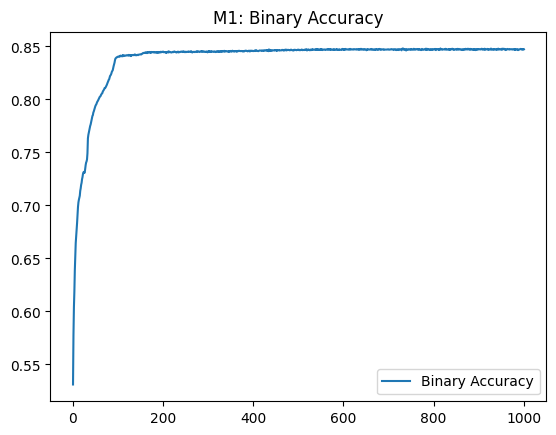

In [79]:
print(model1.count_params())
plot_history(history, 'M1')

In [80]:
# Second model: does an extra unit reduction
## Doesn't actually change much although
## some obtained results are extremely performant
def create_model_2(hidden_dense_1_size=256, plot_model=False, model_name='model2'):
    # Create the input units
    inputs = gen_unit_inputs(len(x_train))
    
    # Create the units on the inputs
    x = gen_units(inputs, size=2, activation='relu')
    
    # Unit reduction to size 3
    x = layers.concatenate(reduce_units(x, size=3, activation='relu'))
    
    # Hidden dense layer
    x = layers.Dense(hidden_dense_1_size, activation='relu', name='hidden_dense_1')(x)
    
    # Output layer
    outputs = layers.Dense(S, activation='sigmoid', name='output')(x)
    
    # Create the model
    model = keras.Model(inputs=inputs,
                        outputs=outputs)
    
    # Plot the model if specified
    if plot_model:
        keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=True,
            show_layer_activations=True,
            to_file=f'{model_name}.png',
        )
    
    # Return the model
    return model

In [81]:
## Take results with a pinch of salt, can be very variable
## Train gets more gradual the lower the size
## Ran on 512 epochs
## Sizes with error: 16 (0.6984), 32 (0.8699), 64 (0.8585), 128 (0.8697), 256 (0.8330), 512 (0.80), 1024 (0.8673)
model2 = create_model_2(hidden_dense_1_size=128, plot_model=True)

OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['binary_accuracy']

EPOCHS = 500
BATCH_SIZE = 512 
## Doesn't change convergence much deteriorates after 512. 
## Curve gets a lot steeper with higher batch size.
## Makes sense as then epoch size needs to increase for
## to reach convergence
## Huge impact on speed

model2.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)

history = model2.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Epoch 1/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - binary_accuracy: 0.5327 - loss: 0.6871
Epoch 2/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - binary_accuracy: 0.5899 - loss: 0.6410
Epoch 3/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - binary_accuracy: 0.6211 - loss: 0.6006
Epoch 4/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - binary_accuracy: 0.6668 - loss: 0.5464
Epoch 5/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - binary_accuracy: 0.6977 - loss: 0.5026
Epoch 6/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - binary_accuracy: 0.7140 - loss: 0.4781
Epoch 7/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - binary_accuracy: 0.7318 - loss: 0.4552
Epoch 8/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - binary_accuracy: 0.7485 - loss: 0.4329
Epoch 9/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - binary_accuracy: 0.7579 - loss: 0.4162
Epoch 10/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - binary_accuracy: 0.7736 - loss: 0.3963
Epoch 11/500
128/128 ━━━━━━━━━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - binary_accuracy: 0.9498 - loss: 0.0921
Epoch 126/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - binary_accuracy: 0.9499 - loss: 0.0918
Epoch 127/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - binary_accuracy: 0.9500 - loss: 0.0914
Epoch 128/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - binary_accuracy: 0.9508 - loss: 0.0910
Epoch 129/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - binary_accuracy: 0.9500 - loss: 0.0909
Epoch 130/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - binary_accuracy: 0.9502 - loss: 0.0909
Epoch 131/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - binary_accuracy: 0.9510 - loss: 0.0898
Epoch 132/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - binary_accuracy: 0.9510 - loss: 0.0903
Epoch 133/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - binary_accuracy: 0.9517 - loss: 0.0891
Epoch 134/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - binary_accuracy: 0.9517 - loss: 0.0892
Epoch 135/500
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - binary_accuracy: 0.9788 - loss: 0.0542
Epoch 250/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - binary_accuracy: 0.9787 - loss: 0.0538
Epoch 251/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - binary_accuracy: 0.9794 - loss: 0.0534
Epoch 252/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - binary_accuracy: 0.9792 - loss: 0.0532
Epoch 253/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - binary_accuracy: 0.9794 - loss: 0.0528
Epoch 254/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - binary_accuracy: 0.9790 - loss: 0.0531
Epoch 255/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - binary_accuracy: 0.9798 - loss: 0.0525
Epoch 256/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - binary_accuracy: 0.9799 - loss: 0.0521
Epoch 257/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - binary_accuracy: 0.9797 - loss: 0.0521
Epoch 258/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - binary_accuracy: 0.9796 - loss: 0.0519
Epoch 259/500
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - binary_accuracy: 0.9893 - loss: 0.0321
Epoch 374/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - binary_accuracy: 0.9896 - loss: 0.0318
Epoch 375/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - binary_accuracy: 0.9897 - loss: 0.0316
Epoch 376/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - binary_accuracy: 0.9894 - loss: 0.0320
Epoch 377/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - binary_accuracy: 0.9897 - loss: 0.0317
Epoch 378/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - binary_accuracy: 0.9898 - loss: 0.0316
Epoch 379/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - binary_accuracy: 0.9893 - loss: 0.0318
Epoch 380/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - binary_accuracy: 0.9899 - loss: 0.0315
Epoch 381/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - binary_accuracy: 0.9894 - loss: 0.0316
Epoch 382/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - binary_accuracy: 0.9896 - loss: 0.0315
Epoch 383/500
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - binary_accuracy: 0.9936 - loss: 0.0208
Epoch 498/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - binary_accuracy: 0.9940 - loss: 0.0203
Epoch 499/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - binary_accuracy: 0.9942 - loss: 0.0200
Epoch 500/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - binary_accuracy: 0.9940 - loss: 0.0203


2933


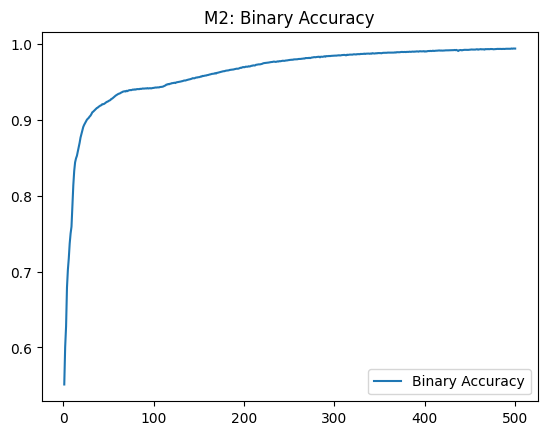

In [82]:
print(model2.count_params())
plot_history(history, 'M2')

In [18]:
# Model that uses 3 unit layers

## Over 1000 epochs without the dense layer,
## performance does not improve significantly
## meaning convergence around 0.65

## Changing batch size has similar results

## Dense layer 64: 0.7305 at 500 epochs
## Dense layer 128: 0.8072 at 500 epochs

## Size of units: 5, 5, 5, dense layer 128: 0.9508 at 500 epochs
## Size of units: 5, 5, 5, no dense layer: 0.8346 at 500 epochs 
## Units: 2, 5, 7: no dense layer: 0.7973 at 500 epochs
## Units: 3, 7, 7, no dense: 0.8964 at 500 epochs
## Units: 7, 5, 3, no dense: 0.7638 at 500 epochs
## Units: 4, 8, 8, no dense: 0.8639 at 500 epochs
## Units: 4, 8, 16, no dense: 0.8984 at 500 epochs
## Units: 8, 8, 8, no dense: 0.8927 at 500 epochs
## Units: 3, 7, 7, dense 32: 1 at 130 epochs
## Units: 2, 6, 6, dense 32: 0.8696 at 500 epochs
## Units: 2, 7, 6, dense 32: 0.7589 at 500 epochs
## Units: 3, 6, 6, dense 32: 0.8742 at 500 epochs
## Units: 3, 7, 8, dense 32: 0.9940 at 500 epochs
## Units: 4, 8, 8, dense 16: 0.9452 at 500 epochs
## Units: 4, 10, 10, dense 10: 0.8993 at 500 epochs
## Units: 5, 9, 9, dense 10: 0.9308 at 500 epochs
## Units: 4, 6, 6, dense 16: 0.9033 at 500 epochs
## Units: 4, 4, 4, dense 32: 0.9075 at 500 epochs
## Units: 8, 8, 8, dense 16: 0.9068 at 500 epochs
## Units: 3, 7, 8, dense 16: 0.9008 at 500 epochs
## Units: 4, 6, 6, dense 16: 0.8825 at 500 epochs
## Units: 3, 8, 6, dense 32: 0.8660 at 500 epochs
## Units: 4, 6, 6, dense 32: 0.8818 at 500 epochs
## Units: 10, 10, 10, densee 16: 0.9694 at 500 epochs
## Units: 4, 8, 8 dense 32: 1 at 190 epochs
## Units: 4, 8, 8 dense 28: 1 at 180 epochs
## Units: 4, 7, 7 dense 28: 1 at 500 epochs
## Units: 4, 7, 7 dense 24: 0.9423 at 500 epochs
## Units: 4, 8, 8 dense 24: 1 at 450 epochs
## Units: 4, 8, 8, dense 20: 0.9916 at 500 epochs
## Untis: 4, 8, 8, dense 16: 0.9489 at 500 epochs
## Units: 4, 8, 8, dense 12: 0.9349 at 500 epochs
## Units: 4, 8, 8, dense 8: 0.8396 at 500 epochs
## Units: 4, 8, 8, dense 10: 0.9202 at 500 epochs
## Units: 4, 8, 8, dense 8: 0.8831 at 1000 epochs gonna be hard to get better with this layer config
## Units: 4, 8, 8, dense 10: 0.9534 at 10000 epochs
## Units: 16, 16, 16, no dense: 0.9004 at 500 epochs
## Units: 16, 8, 4, no dense: 0.7853 at 500 epochs

def create_model_3(plot_model=False, model_name='model3'):
    inputs = gen_unit_inputs(len(x_train))
    
    # Here are the three unit reduction layers
    x = gen_units(inputs, size=16, activation='relu')
    x = reduce_units(x, size=8, activation='relu', unit_name='first_reducer_unit')
    x = layers.concatenate(reduce_units(x, size=4, activation='relu', unit_name='second_reducer_unit'))
    
    # Dense layer
    # x = layers.Dense(10, activation='relu', name='post_reduction_dense')(x)
    
    # Outputs
    outputs = layers.Dense(S, activation='sigmoid', name='outputs')(x)
    
    model = keras.Model(
        inputs=inputs,
        outputs=outputs
    )
    
    if plot_model:
        keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=True,
            show_layer_activations=True,
            to_file=f'{model_name}.png',
        )
    
    return model

In [19]:
# Create the third model
model3 = create_model_3(plot_model=True)

# Define model parameters
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['binary_accuracy']

EPOCHS = 500
BATCH_SIZE = 512

model3.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)

history = model3.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Epoch 1/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - binary_accuracy: 0.5185 - loss: 0.6913
Epoch 2/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.5806 - loss: 0.6697
Epoch 3/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6365 - loss: 0.6143
Epoch 4/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6712 - loss: 0.5482
Epoch 5/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6873 - loss: 0.5118
Epoch 6/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7011 - loss: 0.4952
Epoch 7/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7063 - loss: 0.4859
Epoch 8/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7158 - loss: 0.4794
Epoch 9/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7137 - loss: 0.4754
Epoch 10/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7126 - loss: 0.4711
Epoch 11/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - bin

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7347 - loss: 0.4080
Epoch 65/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7349 - loss: 0.4073
Epoch 66/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7352 - loss: 0.4052
Epoch 67/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7365 - loss: 0.4053
Epoch 68/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7357 - loss: 0.4034
Epoch 69/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7383 - loss: 0.4033
Epoch 70/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7384 - loss: 0.4027
Epoch 71/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7395 - loss: 0.4020
Epoch 72/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7393 - loss: 0.4015
Epoch 73/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7405 - loss: 0.4013
Epoch 74/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7468 - loss: 0.3869
Epoch 128/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7466 - loss: 0.3860
Epoch 129/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7453 - loss: 0.3866
Epoch 130/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7458 - loss: 0.3861
Epoch 131/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7465 - loss: 0.3855
Epoch 132/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7482 - loss: 0.3866
Epoch 133/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7478 - loss: 0.3858
Epoch 134/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7483 - loss: 0.3854
Epoch 135/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7486 - loss: 0.3851
Epoch 136/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7498 - loss: 0.3848
Epoch 137/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7724 - loss: 0.3670
Epoch 191/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7725 - loss: 0.3667
Epoch 192/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7713 - loss: 0.3669
Epoch 193/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7714 - loss: 0.3673
Epoch 194/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7744 - loss: 0.3666
Epoch 195/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7728 - loss: 0.3661
Epoch 196/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7732 - loss: 0.3658
Epoch 197/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7725 - loss: 0.3664
Epoch 198/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7725 - loss: 0.3666
Epoch 199/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7729 - loss: 0.3654
Epoch 200/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7722 - loss: 0.3618
Epoch 254/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7702 - loss: 0.3629
Epoch 255/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7713 - loss: 0.3615
Epoch 256/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7720 - loss: 0.3613
Epoch 257/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7702 - loss: 0.3622
Epoch 258/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7710 - loss: 0.3619
Epoch 259/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7704 - loss: 0.3617
Epoch 260/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7713 - loss: 0.3619
Epoch 261/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7707 - loss: 0.3608
Epoch 262/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7720 - loss: 0.3624
Epoch 263/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7828 - loss: 0.3452
Epoch 317/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7808 - loss: 0.3468
Epoch 318/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7826 - loss: 0.3465
Epoch 319/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7812 - loss: 0.3464
Epoch 320/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7826 - loss: 0.3465
Epoch 321/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7820 - loss: 0.3461
Epoch 322/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7825 - loss: 0.3463
Epoch 323/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7826 - loss: 0.3460
Epoch 324/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7818 - loss: 0.3465
Epoch 325/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7832 - loss: 0.3457
Epoch 326/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7841 - loss: 0.3458
Epoch 380/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7847 - loss: 0.3447
Epoch 381/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7862 - loss: 0.3450
Epoch 382/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7863 - loss: 0.3449
Epoch 383/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7846 - loss: 0.3457
Epoch 384/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7854 - loss: 0.3456
Epoch 385/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7855 - loss: 0.3456
Epoch 386/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7859 - loss: 0.3456
Epoch 387/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7841 - loss: 0.3457
Epoch 388/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7866 - loss: 0.3448
Epoch 389/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7826 - loss: 0.3450
Epoch 443/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7825 - loss: 0.3462
Epoch 444/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7848 - loss: 0.3443
Epoch 445/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7861 - loss: 0.3444
Epoch 446/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7850 - loss: 0.3442
Epoch 447/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7862 - loss: 0.3438
Epoch 448/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7838 - loss: 0.3448
Epoch 449/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7858 - loss: 0.3443
Epoch 450/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7855 - loss: 0.3448
Epoch 451/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7868 - loss: 0.3446
Epoch 452/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

1657


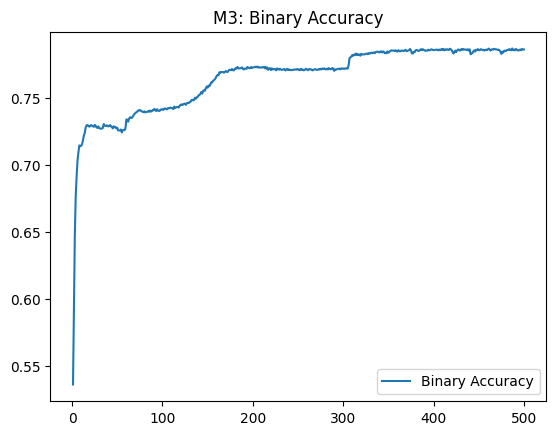

In [20]:
print(model3.count_params())
plot_history(history, 'M3')